### Description of Notebook

This notebook merges the saved files from 'Data Processing 1': "tech_news.csv" and "tech_prices.csv" into a merged_df: "merged_data.csv". 

Method: For each row of news (e.g. at day 0), we append the open and close price from day 1, and the close price from day 3. Percentage change from day 1's open to day 3's close is calculated, and a direction (1 for up, -1 for down) is calculated for this value.

Therefore, the new columns are: '1d_open', '1d_close', '3d_close', '3d_change', '3d_direction'

In [1]:
import pandas as pd
import numpy as np

df_news = pd.read_csv("Data/tech_news.csv")[["Date", "Article_title", "Stock_symbol", "Url"]]
df_prices = pd.read_csv("Data/tech_prices.csv")

In [2]:
print(len(df_news))
df_news.head()

21755


,Date,Article_title,Stock_symbol,Url
0,2020-06-10 07:33:26+00:00,Tech Stocks And FAANGS Strong Again To Start D...,AAPL,https://www.benzinga.com/government/20/06/1622...
1,2020-06-10 04:14:08+00:00,10 Biggest Price Target Changes For Wednesday,AAPL,https://www.benzinga.com/analyst-ratings/price...
2,2020-06-10 03:53:47+00:00,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",AAPL,https://www.benzinga.com/short-sellers/20/06/1...
3,2020-06-10 03:19:25+00:00,"Deutsche Bank Maintains Buy on Apple, Raises P...",AAPL,https://www.benzinga.com/news/20/06/16219873/d...
4,2020-06-10 02:27:11+00:00,Apple To Let Users Trade In Their Mac Computer...,AAPL,https://www.benzinga.com/news/20/06/16218697/a...


In [3]:
print(len(df_prices))
df_prices.head()

47713


,Unnamed: 0,date,open,high,low,close,adj close,volume,Stock_symbol,Date
0,0,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.580002,34014500,AAPL,2023-12-28
1,1,2023-12-27,192.490005,193.500000,191.089996,193.149994,193.149994,48087700,AAPL,2023-12-27
2,2,2023-12-26,193.610001,193.889999,192.830002,193.050003,193.050003,28919300,AAPL,2023-12-26
3,3,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.600006,37122800,AAPL,2023-12-22
4,4,2023-12-21,196.100006,197.080002,193.500000,194.679993,194.679993,46482500,AAPL,2023-12-21


### Do some data type pre-processing for both news and prices

In [4]:
# Merge news and price data

import pandas as pd
from pytz import timezone

df_news = pd.read_csv("Data/tech_news.csv")[["Date", "Article_title", "Stock_symbol", "Url"]]
df_news['Date'] = pd.to_datetime(df_news['Date'], utc=True)
df_news['Date'] = df_news['Date'].dt.tz_convert(timezone('US/Eastern')).dt.floor('D')
df_news['Date'] = df_news['Date'].dt.tz_localize(None)

df_prices = pd.read_csv("Data/tech_prices.csv")
df_prices['Date'] = pd.to_datetime(df_prices['Date'])

df_prices = df_prices.sort_values(by=["Stock_symbol", "Date"])
df_prices['1d_open'] = df_prices.groupby('Stock_symbol')['open'].shift(-1)
df_prices['1d_close'] = df_prices.groupby('Stock_symbol')['close'].shift(-1)
df_prices['3d_close'] = df_prices.groupby('Stock_symbol')['close'].shift(-3)

df_prices = df_prices[['Date', 'Stock_symbol', 'close', '1d_open', '1d_close', '3d_close']]

### Add ARIMA Prediction to Prices

In [5]:
# This part of code is helped by GPT, as it's not NLP related, and just a complicated ARIMA model serving as baseline.
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar
from statsmodels.tsa.stattools import adfuller
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

df = df_prices.copy()
df['Price_Diff'] = df['3d_close'] - df['1d_open']
df['Date'] = pd.to_datetime(df['Date'])
df_news['Date'] = pd.to_datetime(df_news['Date'])

look_back_window = 20

def is_stationary(series, significance_level=0.05):
    result = adfuller(series.dropna())
    return result[1] < significance_level

def process_arima_prediction(stock, group, date, look_back_window):
    try:
        if date not in group.index:
            return None
        
        # Determine the start date for the look-back window
        start_date = date - pd.DateOffset(days=look_back_window)
        
        # Limit the training data to the look-back window
        train_data = group['Price_Diff'].loc[start_date:date]
        
        # Check if the training data is stationary
        if not is_stationary(train_data):
            train_data = train_data.diff().dropna()  # Apply differencing if not stationary
        
        # Fit ARIMA model with a fixed order (1,0,1) since data is differenced manually
        model = ARIMA(train_data, order=(1, 0, 1))  
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=1).iloc[0]
        
        return {'Date': date, 'Predicted_Price_Diff': forecast, 'Stock_symbol': stock}
    
    except Exception as e:
        print(f"ARIMA model failed for {stock} on {date}: {e}")
        return None

# Prepare tasks for sequential processing
tasks = []

# Iterate over each unique stock symbol in the price data
all_stock_symbols = df['Stock_symbol'].unique()

for stock_symbol in all_stock_symbols:
    stock_news_dates = set(df_news[df_news['Stock_symbol'] == stock_symbol]['Date'].unique())

    # Ensure news dates are valid business days
    business_days = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='B')
    news_dates = stock_news_dates & set(business_days)

    print(f"Filtered business-aligned news dates for {stock_symbol}: {len(news_dates)}")

    # Filter the price data for the current stock
    stock_data = df[df['Stock_symbol'] == stock_symbol].copy()
    stock_data = stock_data.sort_values('Date')  # Ensure chronological order
    stock_data.set_index('Date', inplace=True)

    # Create a full business day index and reindex the group
    business_days = pd.date_range(start=stock_data.index.min(), end=stock_data.index.max(), freq='B')
    stock_data = stock_data.reindex(business_days).ffill()  # Forward fill missing values
    stock_data.index.name = 'Date'
    stock_data.index.freq = 'B'  # Explicitly set the frequency
    
    # Create tasks only for valid news dates specific to this stock
    for date in sorted(news_dates):
        if date in stock_data.index:
            tasks.append((stock_symbol, stock_data, date, look_back_window))

print(f"Total tasks generated for all stocks: {len(tasks)}")

# Run tasks sequentially with a progress bar
predictions = []
with tqdm(total=len(tasks), desc=f"Processing ARIMA Predictions for All Stocks", unit="prediction", miniters=1) as pbar:
    for stock, group, date, look_back_window in tasks:
        result = process_arima_prediction(stock, group, date, look_back_window)
        if result is not None:
            predictions.append(result)
        pbar.update(1)

# Prepare the DataFrame from predictions
predictions_df = pd.DataFrame(predictions)

predictions_df.to_csv("Data/predictions.csv")

Filtered business-aligned news dates for AAPL: 60
Filtered business-aligned news dates for ADBE: 626
Filtered business-aligned news dates for AMD: 85
Filtered business-aligned news dates for AMZN: 28
Filtered business-aligned news dates for BBK: 15
Filtered business-aligned news dates for GOOGL: 366
Filtered business-aligned news dates for GRMN: 809
Filtered business-aligned news dates for HPQ: 236
Filtered business-aligned news dates for IBM: 383
Filtered business-aligned news dates for INTC: 372
Filtered business-aligned news dates for NFLX: 687
Filtered business-aligned news dates for NVDA: 932
Filtered business-aligned news dates for ORCL: 793
Filtered business-aligned news dates for TSLA: 214
Total tasks generated for all stocks: 5564


Processing ARIMA Predictions for All Stocks:   8%|██▏                       | 466/5564 [00:21<03:51, 22.06prediction/s]


KeyboardInterrupt: 

In [13]:
predictions_df = pd.read_csv("Data/predictions.csv")
predictions_df['Date'] = pd.to_datetime(predictions_df['Date'])

In [14]:
predictions_df

,Unnamed: 0,Date,Predicted_Price_Diff,Stock_symbol
0,0,2020-03-09,13.707690,AAPL
1,1,2020-03-10,1.287118,AAPL
2,2,2020-03-11,-16.747471,AAPL
3,3,2020-03-12,1.384205,AAPL
4,4,2020-03-13,-5.142878,AAPL
...,...,...,...,...
5559,5559,2020-05-28,-13.804874,TSLA
5560,5560,2020-05-29,8.150960,TSLA
5561,5561,2020-06-01,-36.314547,TSLA
5562,5562,2020-06-09,2.927330,TSLA


### Merge the two dataframes

In [7]:
# First merge predictions onto df_prices
df_prices_arima = df_prices.merge(predictions_df, on=['Date', 'Stock_symbol'], how='left')

In [8]:
# Left join on the news data
merged_df = pd.merge(
    df_news, 
    df_prices_arima, 
    how='right', 
    left_on=['Stock_symbol', 'Date'], 
    right_on=['Stock_symbol', 'Date']
)

merged_df["3d_change"] = (merged_df['3d_close'] - merged_df['1d_open']) / merged_df['1d_open'] * 100

merged_df["3d_direction"] = merged_df["3d_change"].apply(lambda x: 1 if x > 0 else -1)

merged_df["arima_3d_direction"] = merged_df["Predicted_Price_Diff"].apply(lambda x: 1 if x > 0 else -1)

# merged_df = merged_df.drop(columns=['merge_date', 'Date_y']).rename(columns={'Date_x': 'Date'})
print(len(merged_df))
merged_df.head()

59071


,Date,Article_title,Stock_symbol,Url,close,1d_open,1d_close,3d_close,Unnamed: 0,Predicted_Price_Diff,3d_change,3d_direction,arima_3d_direction
0,2009-08-17,NaN,AAPL,NaN,22.798571,23.090000,23.428572,23.761429,NaN,NaN,2.907876,1,-1
1,2009-08-18,NaN,AAPL,NaN,23.428572,23.250000,23.514286,24.174286,NaN,NaN,3.975423,1,-1
2,2009-08-19,NaN,AAPL,NaN,23.514286,23.568571,23.761429,24.151428,NaN,NaN,2.473027,1,-1
3,2009-08-20,NaN,AAPL,NaN,23.761429,23.950001,24.174286,24.200001,NaN,NaN,1.043841,1,-1
4,2009-08-21,NaN,AAPL,NaN,24.174286,24.302856,24.151428,23.915714,NaN,NaN,-1.592990,-1,-1


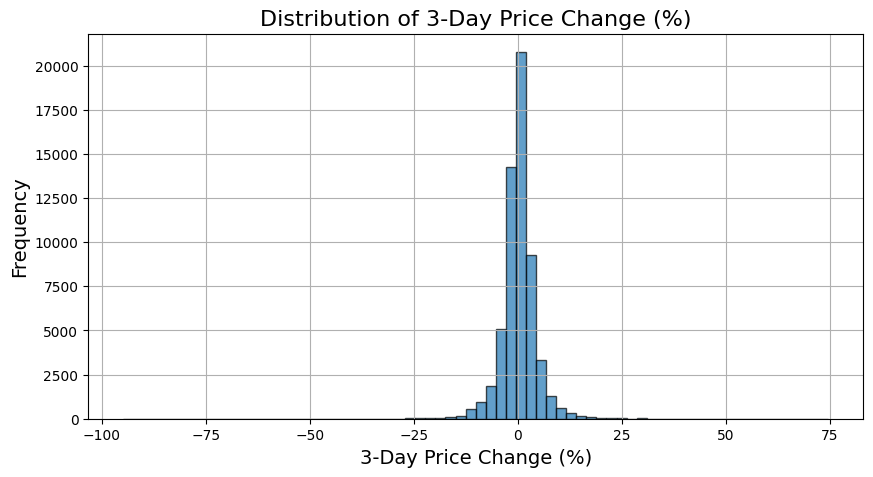

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(merged_df['3d_change'].dropna(), bins=70, edgecolor='k', alpha=0.7)
plt.title('Distribution of 3-Day Price Change (%)', fontsize=16)
plt.xlabel('3-Day Price Change (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True)
plt.show()

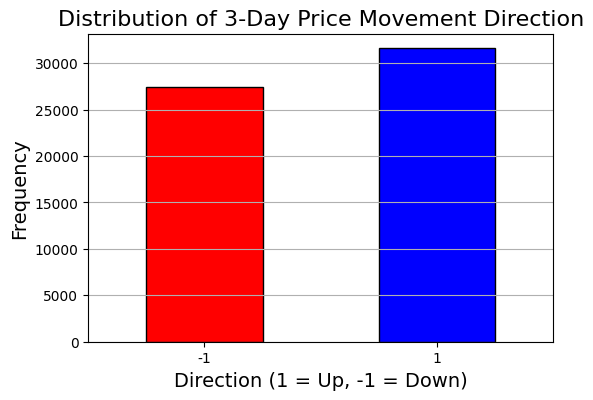

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
merged_df["3d_direction"].value_counts().sort_index().plot(
    kind='bar', 
    color=['red', 'blue'], 
    edgecolor='k'
)

plt.title('Distribution of 3-Day Price Movement Direction', fontsize=16)
plt.xlabel('Direction (1 = Up, -1 = Down)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()


In [11]:
merged_df

,Date,Article_title,Stock_symbol,Url,close,1d_open,1d_close,3d_close,Unnamed: 0,Predicted_Price_Diff,3d_change,3d_direction,arima_3d_direction
0,2009-08-17,NaN,AAPL,NaN,22.798571,23.090000,23.428572,23.761429,NaN,NaN,2.907876,1,-1
1,2009-08-18,NaN,AAPL,NaN,23.428572,23.250000,23.514286,24.174286,NaN,NaN,3.975423,1,-1
2,2009-08-19,NaN,AAPL,NaN,23.514286,23.568571,23.761429,24.151428,NaN,NaN,2.473027,1,-1
3,2009-08-20,NaN,AAPL,NaN,23.761429,23.950001,24.174286,24.200001,NaN,NaN,1.043841,1,-1
4,2009-08-21,NaN,AAPL,NaN,24.174286,24.302856,24.151428,23.915714,NaN,NaN,-1.592990,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59066,2023-12-21,NaN,TSLA,NaN,254.500000,256.760010,252.539993,261.440002,NaN,NaN,1.822711,1,-1
59067,2023-12-22,NaN,TSLA,NaN,252.539993,254.490005,256.609985,253.179993,NaN,NaN,-0.514760,-1,-1
59068,2023-12-26,NaN,TSLA,NaN,256.609985,258.350006,261.440002,NaN,NaN,NaN,NaN,-1,-1
59069,2023-12-27,NaN,TSLA,NaN,261.440002,263.660004,253.179993,NaN,NaN,NaN,NaN,-1,-1


In [12]:
merged_df.to_csv("Data/merged_data.csv")

In [12]:
# merged_df.to_csv("Data/merged_data_fullprice.csv")